In [3]:
import os
import cv2
import numpy as np
import time

import torchvision
import torch.nn.functional as F
import torch
from torch import nn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import Subset
from torch.utils.data import DataLoader

import timm
import seaborn as sns
from tqdm import tqdm

/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def process(img, crop_s = 16, interp_mode = "bilinear", out_size = [300, 225]):
    img = img.transpose(1, 0, 2)
    # print(f"Input shape: {img.shape}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is not None:
        # Crop
        cropped_img = crop(img, crop_s)

        # Interpolation
        scale_factor = 300 / cropped_img.shape[0]
        sigma = scale_factor * 0.5
        cropped_img = interpolate(cropped_img, 5, sigma, int_mode = interp_mode, size = out_size)
        cropped_img = cropped_img.transpose(1, 2, 0)

        # Retransform
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
        cropped_img = cropped_img.transpose(1, 0, 2)

        # Adding to array for saving as .npy
        # print(f"Output shape: {cropped_img.shape}")
        return np.array(cropped_img)

def crop(img, crop_s = 16):
    w, h, c = img.shape

    # Crop x pixels from the top and bottom
    if h > 270:
        img = img[:, crop_s:h - crop_s, :]
    #print(img.shape)
    return img

def interpolate(img, kernel_size = 5, sigma = 0.1, int_mode = "bilinear", size = [300, 225]):
    img = torch.tensor(img)
    # Blur for noise reduc
    blur = torchvision.transforms.GaussianBlur(kernel_size, sigma)
    blured_img = blur(img)
    blured_img = blured_img.transpose(0, 2)
    blured_img = blured_img.transpose(1, 2)
    # print(blured_img.shape)
    interpolated_img = F.interpolate(blured_img.unsqueeze(0), size, mode= int_mode)
    interpolated_img = interpolated_img.squeeze(0)
    # print(interpolated_img.shape)
    return interpolated_img.detach().numpy()

def downsample(data):
    d1 = cv2.pyrDown(data)
    d2 = cv2.pyrDown(d1)
    # d3 = cv2.pyrDown(d2)
    print("Original shape: ", data.shape, "Downsampled shape: ", d2.shape)
    return np.array(d2)

def upsample(data):
    d1 = cv2.pyrUp(data)
    d2 = cv2.pyrUp(d1)
    # d3 = cv2.pyrDown(d2)
    print("Original shape: ", data.shape, "Downsampled shape: ", d2.shape)
    return np.array(d2)


def fungi_collate_fn(batch):
    images, class_ids, toxicities, img_names = [], [], [], []
    for image, (class_id, toxicity), img_name in batch:
        # print(f"Individual image shape: {image.shape}")  # Should be [C, H, W]
        images.append(image)
        class_ids.append(class_id)
        toxicities.append(toxicity)
        img_names.append(img_name)

    images = torch.stack(images)  # Should result in shape [batch_size, C, H, W]
    #print(f"Batch images shape after stacking: {images.shape}")

    class_ids = torch.tensor(class_ids, dtype=torch.long)
    toxicities = torch.tensor(toxicities, dtype=torch.long)

    return images, (class_ids, toxicities), img_names

In [5]:
import torch
import torch.nn as nn
import timm  # PyTorch Image Models

class HybridHead(nn.Module):
    def __init__(self, in_features, num_species_classes, num_toxicity_classes):
        super(HybridHead, self).__init__()
        # Attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=in_features, num_heads=8)
        # State Space Model (SSM) component
        self.ssm = nn.LSTM(in_features, in_features, batch_first=True)
        # Fully connected layers for species classification
        self.fc_species = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_species_classes)
        )
        # Fully connected layers for toxicity prediction
        self.fc_toxicity = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_toxicity_classes)
        )

    def forward(self, x):
        # Attention mechanism
        attn_output, _ = self.attention(x, x, x)
        # State Space Model (SSM) component
        ssm_output, _ = self.ssm(attn_output)
        # Global average pooling
        pooled_output = ssm_output.mean(dim=1)
        # Species classification
        species_output = self.fc_species(pooled_output)
        # Toxicity prediction
        toxicity_output = self.fc_toxicity(pooled_output)
        return species_output, toxicity_output

class FungiClassifier(nn.Module):
    def __init__(self, num_species_classes, num_toxicity_classes):
        super(FungiClassifier, self).__init__()
        # Pre-trained EfficientNet backbone
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        in_features = self.backbone.num_features
        # Hybrid head
        self.head = HybridHead(in_features, num_species_classes, num_toxicity_classes)

    def forward(self, x):
        # Feature extraction
        features = self.backbone(x)
        # Expand dimensions to match attention input requirements
        features = features.unsqueeze(1)
        # Hybrid head
        species_output, toxicity_output = self.head(features)
        return species_output, toxicity_output

device='cpu'
model = FungiClassifier(100, 2)
model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Adjust learning rate as needed

# Define loss functions
criterion_species = nn.CrossEntropyLoss()
criterion_toxicity = nn.CrossEntropyLoss()


In [6]:
class FungiDataset(Dataset):
    def __init__(self, image_dir, labels_path, pre_load=True, crop_height=16, interpolate="bilinear", out_size=(300, 225), transform=None, class_ids_to_include=None):
        '''
        Args:
            image_dir: directory containing the images
            labels_path: path to the labels CSV file
            pre_load: True if images should be loaded into memory, False otherwise
            crop_height: Height for cropping images
            interpolate: Interpolation method
            out_size: Output size for resized images
            transform: Optional transform to be applied on a sample.
        '''
        self.image_dir = image_dir
        self.labels_path = labels_path
        self.pre_load = pre_load
        self.crop_h = crop_height
        self.interpolate = interpolate
        self.out_size = out_size
        self.transform = transform
        self.load_num = 0

        # Load metadata
        metadata = pd.read_csv(self.labels_path)

        # Filter to include only existing imgs
        image_files = set(os.listdir(self.image_dir))
        metadata = metadata[metadata['image_path'].isin(image_files)]

        if metadata.empty:
            raise ValueError('No matching images found in the image directory')

        # **Filter to include only specified class IDs**
        if class_ids_to_include is not None:
            metadata = metadata[metadata['class_id'].isin(class_ids_to_include)]
            metadata.reset_index(drop=True, inplace=True)

        # Reset index after filtering
        metadata.reset_index(drop=True, inplace=True)

        # Ensure labels are integers
        metadata['class_id'] = metadata['class_id'].astype(int)
        metadata['poisonous'] = metadata['poisonous'].astype(int)

        # **Remap class IDs to a continuous range starting from 0**
        unique_class_ids = sorted(metadata['class_id'].unique())
        class_id_to_idx = {original_id: idx for idx, original_id in enumerate(unique_class_ids)}
        metadata['class_id'] = metadata['class_id'].map(class_id_to_idx)

        # Update class IDs and calculate the number of species classes
        self.metadata = metadata
        self.image_paths = metadata['image_path'].tolist()
        self.class_ids = metadata['class_id'].tolist()
        self.toxicities = metadata['poisonous'].tolist()
        self.num_species_classes = len(unique_class_ids)

        # Pre-load images if required
        if self.pre_load:
            self.images = []
            for img_name in self.image_paths:
                img_path = os.path.join(self.image_dir, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Image {img_path} could not be read.")
                    continue

                img_processed = process(img, crop_s=self.crop_h, interp_mode=self.interpolate, out_size=self.out_size)
                # Convert image to tensor and float32
                image = torch.from_numpy(img_processed).float()
                image = image.permute(2, 0, 1)

                # Normalize using ImageNet mean and std
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                image = (image - mean) / std
                self.images.append(image)
                self.load_num += 1
                if self.load_num / 3 == 0:
                  print(f"{self.load_num / 1000} images loaded")
        else:
            self.images = None  # Images will be loaded in __getitem__

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if self.pre_load:
            image = self.images[idx]
        else:
            img_name = self.image_paths[idx]
            img_path = os.path.join(self.image_dir, img_name)

            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Image at {img_path} could not be read.")

            image_processed = process(img, crop_s=self.crop_h, interp_mode=self.interpolate, out_size=self.out_size)

            # Convert image to tensor and float32
            img_tensor = torch.from_numpy(image_processed).float().permute(2, 0, 1)

            # Normalize using ImageNet mean and std
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = (img_tensor - mean) / std

            '''
            print(image.shape)
            print(f"Image dtype: {image.dtype}")  # Should be torch.float32
            print(f"Image min: {image.min()}, max: {image.max()}")  # Should be within expected range
            '''

        # labels
        class_id = self.class_ids[idx]
        toxicity = self.toxicities[idx]

        return image, (class_id, toxicity), img_name


In [7]:
config = {
    "image_dir": "/Users/dkocsis_local/Downloads/data",
    "labels_path": "/Users/dkocsis_local/Downloads/train_metadata_height.csv",
    "pre_load": False,
    "batch_size": 64,
    "crop_height": 16,
    "interpolate": "bilinear",
    "out_size": (224, 224)
}

# Define the classes to include (your list of unique class IDs)
class_ids_to_include = [4, 11, 16, 25, 30, 32, 37, 39, 43, 63, 100, 103, 128, 129, 131, 136, 142, 168, 180, 213, 214, 223, 252, 266, 309, 366, 389, 413, 473, 478, 487, 522, 555, 559, 591, 633, 637, 657, 671, 673, 689, 694, 724, 728, 738, 748, 764, 787, 812, 814, 830, 837, 845, 856, 884, 908, 909, 912, 967, 975, 989, 992, 1000, 1005, 1014, 1020, 1052, 1054, 1088, 1093, 1115, 1121, 1135, 1136, 1141, 1160, 1183, 1207, 1214, 1220, 1221, 1232, 1239, 1242, 1290, 1302, 1355, 1381, 1395, 1420, 1438, 1440, 1481, 1484, 1493, 1533, 1537, 1546, 1573, 1603]

# Initialize the full dataset
full_dataset = FungiDataset(
    image_dir=config["image_dir"],
    labels_path=config["labels_path"],
    pre_load=config["pre_load"],
    crop_height=config["crop_height"],
    interpolate=config["interpolate"],
    out_size=config["out_size"],
    transform=None,
    class_ids_to_include=class_ids_to_include  # Pass the list of class IDs
)

print(f"Number of samples in dataset: {len(full_dataset)}")

# Split into training and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(full_dataset))), test_size=0.2, random_state=42
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=0,
    prefetch_factor=None,  # Prefetch batches to improve performance
    pin_memory=True,  # Optimize for GPU
    collate_fn=fungi_collate_fn,
    drop_last=True  # Drops the last incomplete batch
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=0,
    prefetch_factor=None,
    pin_memory=True,
    collate_fn=fungi_collate_fn,
    drop_last=True # also
)

print(f"Length of train_loader: {len(train_loader)} and val_loader: {len(val_loader)}")

Number of samples in dataset: 25763
Length of train_loader: 322 and val_loader: 80


In [8]:
# Get a batch of data
images, (class_ids, toxicities), _ = next(iter(train_loader))

# Check the range of class_ids
print(f"Class IDs in batch: {class_ids}")
print(f"Min class ID: {class_ids.min()}, Max class ID: {class_ids.max()}")

# Ensure class IDs are in the range [0, num_species_classes - 1]
assert class_ids.min() >= 0 and class_ids.max() < 100

Class IDs in batch: tensor([99, 41, 57, 25, 52, 73, 61,  3,  2, 32, 20, 57, 50, 39,  8,  1, 75, 26,
        49, 91, 31,  1, 74, 89, 33, 18, 35, 19, 50, 13, 21, 15, 87, 25,  7, 88,
        72, 79, 85, 71, 73, 36, 96, 30, 31,  0, 94, 79, 22, 47, 39, 61, 80, 62,
        27, 10, 47,  9, 36, 67, 10, 82,  0, 15])
Min class ID: 0, Max class ID: 99


In [13]:
from sklearn.metrics import confusion_matrix,classification_report
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, alpha = 1.0, beta = 0.6):
    train_losses = []
    val_losses = []
    train_accuracies_species = []
    train_accuracies_toxicity = []
    val_accuracies_species = []
    val_accuracies_toxicity = []
    best_val_acc=0
    earlys=0
    max_earlys=4
    best_not_saved=0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss = 0.0
        correct_species = 0
        correct_toxicity = 0
        total_samples = 0

        # Iterate over batches
        for batch_idx, (images, (class_ids, toxicities), _) in enumerate(train_loader):
            images = images.to(device)
            class_ids = class_ids.to(device, dtype=torch.long)
            toxicities = toxicities.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(images)
            loss_species = criterion_species(outputs[0], class_ids)
            loss_toxicity = criterion_toxicity(outputs[1], toxicities)
            loss = alpha * loss_species + beta * loss_toxicity  # weighting

            loss.backward()
            optimizer.step()

            # Update running loss
            batch_loss = loss.item() * images.size(0)
            running_loss += batch_loss

            # Calculate accuracies
            _, preds_species = torch.max(outputs[0], 1)
            _, preds_toxicity = torch.max(outputs[1], 1)
            batch_correct_species = (preds_species == class_ids).sum().item()
            batch_correct_toxicity = (preds_toxicity == toxicities).sum().item()
            batch_samples = images.size(0)
            correct_species += batch_correct_species
            correct_toxicity += batch_correct_toxicity
            total_samples += batch_samples

            # Calculate batch accuracies
            batch_accuracy_species = batch_correct_species / batch_samples * 100
            batch_accuracy_toxicity = batch_correct_toxicity / batch_samples * 100
            # Print per-batch metrics
            print(f"Train Batch {batch_idx+1}/{len(train_loader)}: Loss = {loss.item():.4f}, Species Acc = {batch_accuracy_species:.2f}%, Toxicity Acc = {batch_accuracy_toxicity:.2f}%")
            

        avg_train_loss = running_loss / total_samples
        train_losses.append(avg_train_loss)
        train_accuracy_species = correct_species / total_samples * 100
        train_accuracy_toxicity = correct_toxicity / total_samples * 100
        train_accuracies_species.append(train_accuracy_species)
        train_accuracies_toxicity.append(train_accuracy_toxicity)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_correct_species = 0
        val_correct_toxicity = 0
        val_total_samples = 0
        val_predictions_species = []
        val_targets_species = []
        val_predictions_toxicity = []
        val_targets_toxicity = []

        with torch.no_grad():
            for batch_idx, (images, (class_ids, toxicities), _) in enumerate(val_loader):
                images = images.to(device)
                class_ids = class_ids.to(device, dtype=torch.long)
                toxicities = toxicities.to(device, dtype=torch.long)

                outputs = model(images)

                loss_species = criterion_species(outputs[0], class_ids)
                loss_toxicity = criterion_toxicity(outputs[1], toxicities)
                loss = alpha * loss_species + beta * loss_toxicity  # Adjust weighting

                # Update running loss
                batch_loss = loss.item() * images.size(0)
                val_running_loss += batch_loss

                # Calculate accuracies
                _, preds_species = torch.max(outputs[0], 1)
                _, preds_toxicity = torch.max(outputs[1], 1)
                batch_correct_species = (preds_species == class_ids).sum().item()
                batch_correct_toxicity = (preds_toxicity == toxicities).sum().item()
                batch_samples = images.size(0)
                val_correct_species += batch_correct_species
                val_correct_toxicity += batch_correct_toxicity
                val_total_samples += batch_samples

                # Store predictions and targets for confusion matrices
                val_predictions_species.extend(preds_species.cpu().numpy())
                val_targets_species.extend(class_ids.cpu().numpy())
                val_predictions_toxicity.extend(preds_toxicity.cpu().numpy())
                val_targets_toxicity.extend(toxicities.cpu().numpy())

                # Calculate batch accuracies
                batch_accuracy_species = batch_correct_species / batch_samples * 100
                batch_accuracy_toxicity = batch_correct_toxicity / batch_samples * 100

                # Print per-batch metrics
                print(f"Val Batch {batch_idx+1}/{len(val_loader)}: Loss = {loss.item():.4f}, Species Acc = {batch_accuracy_species:.2f}%, Toxicity Acc = {batch_accuracy_toxicity:.2f}%")

                

        avg_val_loss = val_running_loss / val_total_samples
        val_losses.append(avg_val_loss)
        val_accuracy_species = val_correct_species / val_total_samples * 100
        val_accuracy_toxicity = val_correct_toxicity / val_total_samples * 100
        val_accuracies_species.append(val_accuracy_species)
        val_accuracies_toxicity.append(val_accuracy_toxicity)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Species Acc: {train_accuracy_species:.2f}%, Toxicity Acc: {train_accuracy_toxicity:.2f}%")
        print(f"  Val Loss:   {avg_val_loss:.4f}, Species Acc: {val_accuracy_species:.2f}%, Toxicity Acc: {val_accuracy_toxicity:.2f}%")

        if(epoch>10):
            if(val_accuracy_species>best_val_acc):
                if best_not_saved>5:
                    torch.save(model.state_dict(), 'model.pth')
                    best_not_saved=0
                else:
                    best_not_saved+=1
                best_val_acc=val_accuracy_species
                earlys=0
            else:
                earlys+=1
            if(earlys>max_earlys):
                print("Early stopping")
                break
        # Confusion Matrices
        # For Species Classification
        species_correct = np.array(val_predictions_species) == np.array(val_targets_species)
        species_binary_predictions = species_correct.astype(int)  # 1 if correct, 0 if incorrect
        species_binary_targets = np.zeros_like(species_binary_predictions)  # All zeros (1 row for misclassification matrix)

        # Plot Confusion Matrix for Species Classification
        print(classification_report(species_binary_targets, species_binary_predictions))
        print(confusion_matrix(val_targets_species, val_predictions_species))


        # For Toxicity Classification
        toxicity_predictions = np.array(val_predictions_toxicity)
        toxicity_targets = np.array(val_targets_toxicity)

        # Plot Confusion Matrix for Toxicity Classification
        print(classification_report(toxicity_targets, toxicity_predictions))
        print(confusion_matrix(toxicity_targets, toxicity_predictions))


    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies_species': train_accuracies_species,
        'train_accuracies_toxicity': train_accuracies_toxicity,
        'val_accuracies_species': val_accuracies_species,
        'val_accuracies_toxicity': val_accuracies_toxicity
    }

In [14]:

training_stats = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=200
)

# Save the model and statistics
torch.save(model.state_dict(), "multi_task_model.pth")
print("Training completed!")


Epoch 1/200
Train Batch 1/322: Loss = 4.7389, Species Acc = 1.56%, Toxicity Acc = 93.75%
Train Batch 2/322: Loss = 4.7843, Species Acc = 1.56%, Toxicity Acc = 89.06%
Train Batch 3/322: Loss = 4.7049, Species Acc = 0.00%, Toxicity Acc = 93.75%
Train Batch 4/322: Loss = 4.8230, Species Acc = 1.56%, Toxicity Acc = 82.81%
Train Batch 5/322: Loss = 4.6977, Species Acc = 3.12%, Toxicity Acc = 90.62%
Train Batch 6/322: Loss = 4.7529, Species Acc = 0.00%, Toxicity Acc = 92.19%
Train Batch 7/322: Loss = 4.6783, Species Acc = 0.00%, Toxicity Acc = 93.75%
Train Batch 8/322: Loss = 4.7140, Species Acc = 0.00%, Toxicity Acc = 89.06%
Train Batch 9/322: Loss = 4.7653, Species Acc = 1.56%, Toxicity Acc = 93.75%
Train Batch 10/322: Loss = 4.6943, Species Acc = 1.56%, Toxicity Acc = 93.75%
Train Batch 11/322: Loss = 4.7223, Species Acc = 1.56%, Toxicity Acc = 93.75%
Train Batch 12/322: Loss = 4.7143, Species Acc = 1.56%, Toxicity Acc = 93.75%
Train Batch 13/322: Loss = 4.7021, Species Acc = 0.00%, Toxi

/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

Train Batch 1/322: Loss = 3.8059, Species Acc = 7.81%, Toxicity Acc = 96.88%
Train Batch 2/322: Loss = 4.0774, Species Acc = 0.00%, Toxicity Acc = 93.75%
Train Batch 3/322: Loss = 4.0251, Species Acc = 7.81%, Toxicity Acc = 90.62%
Train Batch 4/322: Loss = 3.9504, Species Acc = 0.00%, Toxicity Acc = 95.31%
Train Batch 5/322: Loss = 3.8671, Species Acc = 1.56%, Toxicity Acc = 92.19%
Train Batch 6/322: Loss = 3.8353, Species Acc = 10.94%, Toxicity Acc = 100.00%
Train Batch 7/322: Loss = 3.8715, Species Acc = 1.56%, Toxicity Acc = 92.19%
Train Batch 8/322: Loss = 4.0304, Species Acc = 3.12%, Toxicity Acc = 90.62%
Train Batch 9/322: Loss = 4.0030, Species Acc = 1.56%, Toxicity Acc = 93.75%
Train Batch 10/322: Loss = 3.8378, Species Acc = 6.25%, Toxicity Acc = 92.19%
Train Batch 11/322: Loss = 3.8868, Species Acc = 4.69%, Toxicity Acc = 95.31%
Train Batch 12/322: Loss = 3.8126, Species Acc = 3.12%, Toxicity Acc = 92.19%
Train Batch 13/322: Loss = 3.9911, Species Acc = 3.12%, Toxicity Acc = 

/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

Train Batch 1/322: Loss = 3.2106, Species Acc = 14.06%, Toxicity Acc = 93.75%
Train Batch 2/322: Loss = 3.4851, Species Acc = 10.94%, Toxicity Acc = 95.31%
Train Batch 3/322: Loss = 3.4927, Species Acc = 7.81%, Toxicity Acc = 92.19%
Train Batch 4/322: Loss = 3.2062, Species Acc = 9.38%, Toxicity Acc = 95.31%
Train Batch 5/322: Loss = 3.1456, Species Acc = 15.62%, Toxicity Acc = 96.88%
Train Batch 6/322: Loss = 3.2915, Species Acc = 15.62%, Toxicity Acc = 96.88%
Train Batch 7/322: Loss = 3.4111, Species Acc = 6.25%, Toxicity Acc = 90.62%
Train Batch 8/322: Loss = 3.1772, Species Acc = 15.62%, Toxicity Acc = 100.00%
Train Batch 9/322: Loss = 3.3843, Species Acc = 7.81%, Toxicity Acc = 95.31%
Train Batch 10/322: Loss = 3.1478, Species Acc = 17.19%, Toxicity Acc = 96.88%
Train Batch 11/322: Loss = 3.2767, Species Acc = 7.81%, Toxicity Acc = 96.88%
Train Batch 12/322: Loss = 3.1780, Species Acc = 14.06%, Toxicity Acc = 100.00%
Train Batch 13/322: Loss = 3.0818, Species Acc = 17.19%, Toxicit

/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

Train Batch 1/322: Loss = 2.4314, Species Acc = 26.56%, Toxicity Acc = 95.31%
Train Batch 2/322: Loss = 2.4739, Species Acc = 23.44%, Toxicity Acc = 100.00%
Train Batch 3/322: Loss = 2.3675, Species Acc = 26.56%, Toxicity Acc = 100.00%
Train Batch 4/322: Loss = 2.6921, Species Acc = 15.62%, Toxicity Acc = 96.88%
Train Batch 5/322: Loss = 2.5337, Species Acc = 29.69%, Toxicity Acc = 96.88%
Train Batch 6/322: Loss = 2.5508, Species Acc = 20.31%, Toxicity Acc = 98.44%
Train Batch 7/322: Loss = 2.4844, Species Acc = 29.69%, Toxicity Acc = 92.19%
Train Batch 8/322: Loss = 2.4249, Species Acc = 17.19%, Toxicity Acc = 98.44%
Train Batch 9/322: Loss = 2.1985, Species Acc = 31.25%, Toxicity Acc = 98.44%
Train Batch 10/322: Loss = 2.6779, Species Acc = 18.75%, Toxicity Acc = 98.44%
Train Batch 11/322: Loss = 2.3658, Species Acc = 25.00%, Toxicity Acc = 100.00%
Train Batch 12/322: Loss = 2.3230, Species Acc = 37.50%, Toxicity Acc = 98.44%
Train Batch 13/322: Loss = 2.7915, Species Acc = 23.44%, T

/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

KeyboardInterrupt: 

In [15]:
print(model)
torch.save(model.state_dict(), 'model_dict.pth')
#Save full model
torch.save(model,'full_mode.pth')

FungiClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw

In [16]:
from sklearn.metrics import confusion_matrix,classification_report

def eval(model,loader):
    model.eval()
    val_running_loss = 0.0
    val_correct_species = 0
    val_correct_toxicity = 0
    val_total_samples = 0
    val_predictions_species = []
    val_targets_species = []
    val_predictions_toxicity = []
    val_targets_toxicity = []

    with torch.no_grad():
            for batch_idx, (images, (class_ids, toxicities), _) in enumerate(val_loader):
                images = images.to(device)
                class_ids = class_ids.to(device, dtype=torch.long)
                toxicities = toxicities.to(device, dtype=torch.long)

                outputs = model(images)
                
                # Calculate accuracies
                _, preds_species = torch.max(outputs[0], 1)
                _, preds_toxicity = torch.max(outputs[1], 1)
                batch_correct_species = (preds_species == class_ids).sum().item()
                batch_correct_toxicity = (preds_toxicity == toxicities).sum().item()
                batch_samples = images.size(0)
                val_correct_species += batch_correct_species
                val_correct_toxicity += batch_correct_toxicity
                val_total_samples += batch_samples

                # Store predictions and targets for confusion matrices
                val_predictions_species.extend(preds_species.cpu().numpy())
                val_targets_species.extend(class_ids.cpu().numpy())
                val_predictions_toxicity.extend(preds_toxicity.cpu().numpy())
                val_targets_toxicity.extend(toxicities.cpu().numpy())

    
    
        # Plot Confusion Matrix for Species Classification
    classificatioj_cls=classification_report(val_targets_species, val_predictions_species)
    class_conf=confusion_matrix(val_targets_species, val_predictions_species)
    print(classificatioj_cls)
    print(class_conf)
    np.save("class_conf.npy",class_conf)
        # For Toxicity Classification
    toxicity_predictions = np.array(val_predictions_toxicity)
    toxicity_targets = np.array(val_targets_toxicity)

        # Plot Confusion Matrix for Toxicity Classification
    toxreport=classification_report(toxicity_targets, toxicity_predictions)
    toxconf=confusion_matrix(toxicity_targets, toxicity_predictions)
    np.save("toxconf.npy",toxconf)
    print(toxreport)
    print(toxconf)


eval(model,val_loader)




              precision    recall  f1-score   support

           0       0.37      0.27      0.31        51
           1       0.39      0.50      0.44        66
           2       0.00      0.00      0.00        45
           3       0.19      0.20      0.19        50
           4       0.18      0.11      0.13        47
           5       0.59      0.41      0.49        46
           6       0.24      0.30      0.26        53
           7       0.21      0.45      0.29        49
           8       0.20      0.04      0.07        24
           9       0.28      0.19      0.23        63
          10       0.00      0.00      0.00        42
          11       0.31      0.63      0.42        52
          12       0.40      0.38      0.39        50
          13       0.63      0.63      0.63        57
          14       0.79      0.90      0.84        41
          15       0.50      0.46      0.48        48
          16       0.44      0.69      0.54        48
          17       0.23    

/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkocsis_local/Downloads/FungiCLEF2024_ADC-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

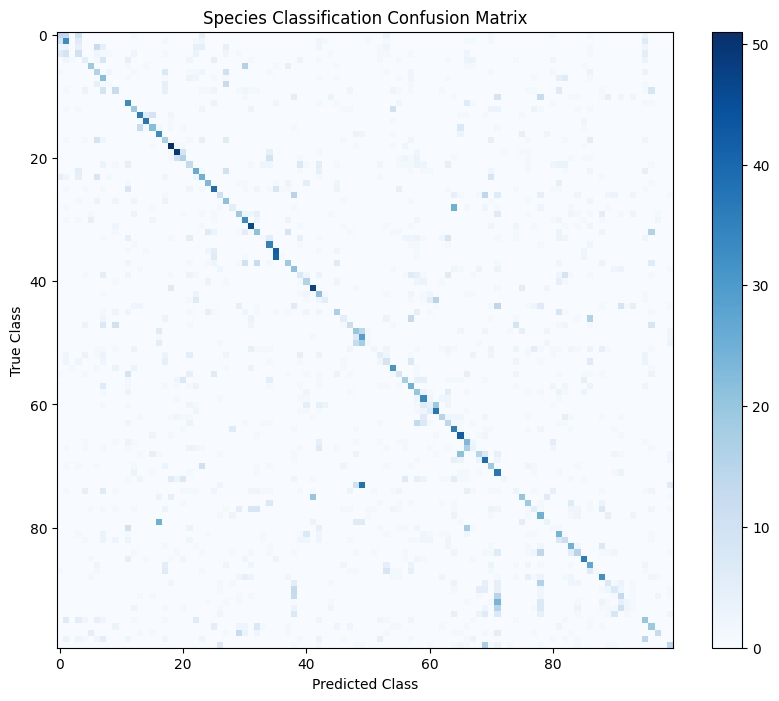

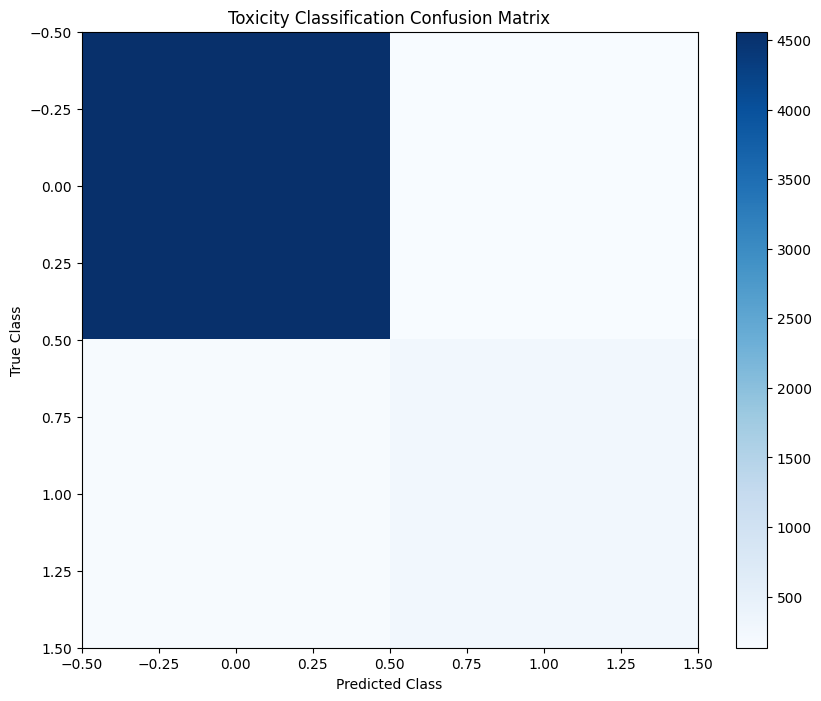

In [17]:
import matplotlib.pyplot as plt
class_conf=np.load("class_conf.npy")
poi_conf=np.load("toxconf.npy")

plt.figure(figsize=(10, 8))
plt.title("Species Classification Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.imshow(class_conf, cmap='Blues')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 8))
plt.title("Toxicity Classification Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.imshow(poi_conf, cmap='Blues')
plt.colorbar()
plt.show()
